Final Project 1: Self-supervised Video Prediction 

MOVING MNIST



*   Ruben Vasquez (Matrikel nr: 3340562 ; Email: s6ruvasq@uni-bonn.de)
*   Rohil Rao (Matrikel nr: 3299480 ; Email: s6roraoo@uni-bonn.de)

    


# Imports



In [1]:
pip install numpngw

In [2]:
pip install av

     |████████████████████████████████| 37.2MB 73kB/s 


In [3]:
pip install kornia

     |████████████████████████████████| 276kB 14.7MB/s 


In [4]:
import matplotlib 
matplotlib.rcParams['figure.dpi'] = 80

In [5]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models.resnet import ResNet, BasicBlock

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time, os, copy
from PIL import Image
import natsort
import cv2
import random 


from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
from tqdm import tqdm

from kornia.losses import ssim_loss
from torchsummary import summary

## Add Seed

In [10]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount = True

Mounted at /content/gdrive


# Conv/ LDC

In [23]:
# Taken from the ResNet pytorch implementation

def Conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def Conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride=stride, bias=False)

In [24]:
# https://github.com/jacobkimmel/pytorch_convgru/blob/master/convgru.py

class ConvGRUCell(nn.Module):
    """
    Generate a convolutional GRU cell
    """

    def __init__(self, input_size, hidden_size, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reset_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.update_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding) 
        self.out_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)

        init.orthogonal_(self.reset_gate.weight)
        init.orthogonal_(self.update_gate.weight)
        init.orthogonal_(self.out_gate.weight)
        init.constant_(self.reset_gate.bias, 0.)
        init.constant_(self.update_gate.bias, 0.)
        init.constant_(self.out_gate.bias, 0.)


    def forward(self, input_, prev_state):

        # get batch and spatial sizes
        batch_size = input_.data.size()[0]
        spatial_size = input_.data.size()[2:]

        # generate empty prev_state, if None is provided
        if prev_state is None:
            state_size = [batch_size, self.hidden_size] + list(spatial_size)
            if torch.cuda.is_available():
                prev_state = Variable(torch.zeros(state_size).to(input_.device))
            else:
                prev_state = Variable(torch.zeros(state_size))

        # data size is [batch, channel, height, width]
        stacked_inputs = torch.cat([input_, prev_state], dim=1)
        update = torch.sigmoid(self.update_gate(stacked_inputs))
        reset = torch.sigmoid(self.reset_gate(stacked_inputs))
        out_inputs = torch.tanh(self.out_gate(torch.cat([input_, prev_state * reset], dim=1)))
        new_state = prev_state * (1 - update) + out_inputs * update

        return new_state

In [25]:
# https://github.com/AIS-Bonn/LocDepVideoPrediction

class LocationAwareConv2d(torch.nn.Conv2d):
    def __init__(self,locationAware,gradient,w,h,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        if locationAware:
            self.locationBias=torch.nn.Parameter(torch.zeros(w,h,3))
            self.locationEncode=torch.autograd.Variable(torch.ones(w,h,3))
            if gradient:
                for i in range(w):
                    self.locationEncode[i,:,1]=self.locationEncode[:,i,0]=i/float(w-1)
        
        self.up=torch.nn.Upsample(size=(w,h), mode='bilinear', align_corners=False)
        self.w=w
        self.h=h
        self.locationAware=locationAware
    def forward(self,inputs):
        if self.locationAware:
            if self.locationBias.device != inputs.device:
                self.locationBias=self.locationBias.to(device)
            if self.locationEncode.device != inputs.device:
                self.locationEncode=self.locationEncode.to(device)
            b=self.locationBias*self.locationEncode
        convRes=super().forward(inputs)
        if convRes.shape[2]!=self.w and convRes.shape[3]!=self.h:
            convRes=self.up(convRes)
        if self.locationAware:
            return convRes+b[:,:,0]+b[:,:,1]+b[:,:,2]
        else:
            return convRes

# Architecture

In [26]:
class Project1_Split(ResNet):
  def __init__(self, channels, height, width):
    super(Project1_Split, self).__init__(BasicBlock, [2, 2, 2, 2])

    '''
    Delete fc layer and maxpool layer
    '''
    del self.avgpool
    del self.fc
    
    
    del self.layer3
    del self.layer4

    '''
    Adapt self.conv1 of Resnet for M-MNIST to check only 1 channel
    '''
    self.conv1 = nn.Conv2d(channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.relu = nn.LeakyReLU(0.1)#nn.ReLU(inplace= False)
    
    '''
    Middle Layer 1 
    '''
    self.m1_conv1x1 =  Conv1x1( in_planes = 64, out_planes = 64)
    self.m1_convgru3x3 = ConvGRUCell(input_size = 64, hidden_size = 64, kernel_size = 3)
    self.m1_convgru5x5 = ConvGRUCell(input_size = 64, hidden_size = 64, kernel_size = 5)
    self.m1_convgru7x7 = ConvGRUCell(input_size = 64, hidden_size = 64, kernel_size = 7)
    
    '''
    Middle Layer 2
    '''
    self.m2_conv1x1 =  Conv1x1( in_planes = 64, out_planes = 64)
    self.m2_convgru3x3 = ConvGRUCell(input_size = 64, hidden_size = 64, kernel_size = 3)
    self.m2_convgru5x5 = ConvGRUCell(input_size = 64, hidden_size = 64, kernel_size = 5)
    self.m2_convgru7x7 = ConvGRUCell(input_size = 64, hidden_size = 64, kernel_size = 7)
    
   
    self.layer7 = nn.Sequential(
                                nn.ReLU(),
                                #nn.LeakyReLU(0.1),
                                Conv3x3(128,1024),
                                nn.PixelShuffle(2),
                                Conv3x3(256,64)
                                )
   
 
    self.layer8 = nn.Sequential(
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                nn.BatchNorm2d(320),
                                Conv3x3(320,1024),
                                nn.PixelShuffle(2), 
                                Conv3x3(256,64)   
                                )
    
    self.output_layer = nn.Sequential(
                                Conv1x1(320, channels),
                                nn.Upsample(scale_factor = 2, mode = 'nearest')
                                )


  def forward(self,x, hidden_states = [], first_frame = True):
      '''
      For the first frame we initialize the hidden states for the ConvGRUs as None Type.
      ''' 
      if (first_frame == True):
        for i in range(12):
          hidden_states.append(None) 
      
      '''
      Assign the values of hidden states to the variables used in the forward pass logic.
      '''

      h1_1 = hidden_states[0]; h1_2 = hidden_states[1]; h1_3 = hidden_states[2]
      h2_1 = hidden_states[3]; h2_2 = hidden_states[4]; h2_3 = hidden_states[5]
      
      x_0 = self.conv1(x)

      x_1 = self.bn1(x_0)
      x_1 = self.relu(x_1)
      x_1 = self.maxpool(x_1)

      x_1 = self.layer1(x_1)  
      x_2 = self.layer2(x_1)
   
      x_7 = self.layer7(x_2)
      x_m2_conv1x1 = self.m2_conv1x1( x_1 )
      x_m2_convgru3x3 = self.m2_convgru3x3( x_1 , h2_1)
      x_m2_convgru5x5 = self.m2_convgru5x5( x_1 , h2_2)
      x_m2_convgru7x7 = self.m2_convgru7x7( x_1 , h2_3)
      x_7_cat = torch.cat((x_7, x_m2_conv1x1, x_m2_convgru3x3, x_m2_convgru5x5, x_m2_convgru7x7), 1)

      x_8 = self.layer8(x_7_cat)
      x_m1_conv1x1 = self.m1_conv1x1( x_0 )
      x_m1_convgru3x3 = self.m1_convgru3x3( x_0 , h1_1 )
      x_m1_convgru5x5 = self.m1_convgru5x5( x_0 , h1_2 )
      x_m1_convgru7x7 = self.m1_convgru7x7( x_0 , h1_3 )
      x_8_cat = torch.cat((x_8, x_m1_conv1x1, x_m1_convgru3x3, x_m1_convgru5x5, x_m1_convgru7x7), 1)

      out = self.output_layer(x_8_cat)

      ''' Maintain/Update Hidden States '''
      hidden_states = [x_m1_convgru3x3, x_m1_convgru5x5, x_m1_convgru7x7 , 
                       x_m2_convgru3x3, x_m2_convgru5x5, x_m2_convgru7x7 , 
                       ]

      return out, hidden_states

# Dataset

In [28]:
class MMNIST_Data(Dataset):
  def __init__(self, path, instances, indices, mode = 'Train'):
    

    if mode == 'Train':
      self.total_data = torch.from_numpy(np.load(path + 'mmnist64_train.npy')) #.transpose((1,0,2,3))
    elif mode == 'Val':
      self.total_data = torch.from_numpy(np.load(path + 'mmnist64_val.npy')) #.transpose((1,0,2,3))
    elif mode == 'Test':
      self.total_data = torch.from_numpy(np.load(path + 'mmnist64_test.npy')) #.transpose((1,0,2,3))
  
    self.indexes = indices



    self.data = self.total_data[self.indexes]/255 #.reshape(instances,6,1,224,224)
    self.data = torch.unsqueeze(self.data, dim = 2)

    norm = transforms.Normalize( (self.data.mean()), (self.data.std()) )
    self.data = norm(self.data)

    del self.total_data


    self.len = len(self.indexes)

  def __getitem__(self, index):
    return [ self.indexes[index],self.data[:,0:3,:,:,:][index], self.data[:,3:6,:,:,:][index] ]

  def __len__(self):
    return self.len

# DataLoader

In [29]:
total = 10000
train_instances = int(0.7*total)
val_instances = int(0.2*total)
test_instances = int(0.1*total)
train_indices = sorted(random.sample(range(0, 7000), train_instances))
val_indices = sorted(random.sample(range(0, 2000), val_instances))
test_indices = sorted(random.sample(range(0, 1000), test_instances))
print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

7000
2000
1000


In [30]:
# Dataset
path = '/content/gdrive/MyDrive/CUDA/MMNIST/'
train_dataset = MMNIST_Data(path = '/content/gdrive/MyDrive/CUDA/MMNIST/', instances = len(train_indices), indices = train_indices,  mode = 'Train')

path = '/content/gdrive/MyDrive/CUDA/MMNIST/'
val_dataset = MMNIST_Data(path = '/content/gdrive/MyDrive/CUDA/MMNIST/', instances = len(val_indices), indices = val_indices,  mode = 'Val')

path = '/content/gdrive/MyDrive/CUDA/MMNIST/'
test_dataset = MMNIST_Data(path = '/content/gdrive/MyDrive/CUDA/MMNIST/', instances = len(train_indices), indices = test_indices, mode = 'Test')

print()
print(len(train_dataset))
print(len(val_dataset)) 
print(len(test_dataset)) 


7000
2000
1000


In [31]:
# Dataloaders
# Batch Size

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True ,num_workers = 0)

batch_size = 64
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False ,num_workers = 0)

batch_size = 3
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False ,num_workers = 0)


# Validation

In [32]:
def validation( epoch, val_loader, model, device , alpha = 0.9, window_size = 3):

  print("*************************** VAL ***************************")
  print("Epoch:",epoch)
        
  Loss_History = [] ; L2_History = [] ;  DSSIM_History = []

  model.eval()

  with torch.no_grad():

    for batch_idx, frames in enumerate(val_loader, 0):
        
        Pred = []
        GT = []
        Val_Loss = torch.zeros(size = (1,1)).to(device) # Reset Accumulated Loss
            
################################################################################################################################################################################################################

      # Iterate over GT0, GT1, GT2 
        for i in range(0,3):
          first_frame = False
          if (i == 0):
            hidden = []
            first_frame = True

          output, hidden = model( frames[1][:,i,:,:,:].reshape(-1,1,height,width).float().to(device) , hidden, first_frame = first_frame)
          #output = torch.clamp(output, min = 0 , max = 1)

        # Append Pred0 and GT3( Output obtained after first 3 input frames to a list)
        Pred.append( output )
        GT.append( frames[2][:,0,:,:,:].reshape(-1,1,height,width).float().to(device) )
          
        # Now run two more times to obtain Pred1 and Pred2 (Also collect GT_1 and GT_2)
        for j in range(1,3):  
          first_frame = False
          output, hidden = model( output , hidden, first_frame = first_frame)

          Pred.append(output)
          GT.append(frames[2][:,j,:,:,:].reshape(-1,1,height,width).float().to(device))
#################################################################################################################################################################################################################

        Pred = torch.cat(Pred, dim = 0)
        GT = torch.cat(GT, dim = 0)

        L2_loss = l2_loss(Pred, GT)
        DSSIM_loss = ssim_loss(Pred, GT, window_size = ssim_window )
        Val_Loss = (1-alpha)*L2_loss + alpha*DSSIM_loss

        #Loss, L2_loss, DSSIM_loss = dssim_l2_loss(gt, pred)
      
        #Loss for all frames
        Loss_History.append(Val_Loss.item())

        L2_History.append(L2_loss.item())
  
        DSSIM_History.append(DSSIM_loss.item())
        if batch_idx%10 == 0:
          print("VAL :: Epoch",epoch,"Batch",batch_idx,"| Loss:",np.round(Val_Loss.item(),4),"| L2:",np.round(L2_loss.item(),4),"| DSSIM:",np.round(DSSIM_loss.item(),4))    

  # Gather images for final batch in epoch
  Images = [frames, Pred ]  

  return sum(Loss_History)/len(Loss_History), sum(L2_History)/len(L2_History), sum(DSSIM_History)/len(DSSIM_History), Images
  

In [33]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()
    plt.pause(1)

# Training

## Initialize parameters

In [34]:
Train_imgs = []

Val_imgs = []

In [35]:
Epoch_Loss = []
Epoch_L2 = []
Epoch_DSSIM = []

Val_Epoch_Loss = []
Val_Epoch_L2 = []
Val_Epoch_DSSIM = []

In [36]:
# Model 

height= 64; width= 64; channels = 1
model = Project1_Split(channels, height, width).to(device)

In [37]:
l2_loss = torch.nn.MSELoss()

In [38]:
for name,param in model.named_parameters():
    if param.requires_grad is True:
        print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
m1_conv1x1.weight True
m1_convgru3x3.reset_gate.weight True
m1_convgru3x3.reset_gate.bias True
m1_convgru3x3.update_gate.weight True
m1_convgru3x3.update_gate.bias True
m1_convgru3x3.out_gate.weight True
m1_convgru3x3.out_gate.bias True
m1_convgru5x5.r

In [39]:
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001) # , weight_decay= 0.0001

optimizer = optim.Adam([
                        {"params":model.conv1.parameters(), "lr": 0.00001},
                        {"params":model.bn1.parameters(), "lr": 0.00001},
                        {"params":model.layer1.parameters(), "lr": 0.00001 },
                        {"params":model.layer2.parameters(), "lr": 0.00001},
                        

                        {"params":model.m1_conv1x1.parameters(), "lr": 0.001 },
                        {"params":model.m1_convgru3x3.parameters(), "lr": 0.001},
                        {"params":model.m1_convgru5x5.parameters(), "lr": 0.001},
                        {"params":model.m1_convgru7x7.parameters(), "lr": 0.001},
                        {"params":model.m2_conv1x1.parameters(), "lr": 0.001},
                        {"params":model.m2_convgru3x3.parameters(), "lr": 0.001},
                        {"params":model.m2_convgru5x5.parameters(), "lr": 0.001},
                        {"params":model.m2_convgru7x7.parameters(),"lr": 0.001},
                       
                       
                        {"params":model.layer7.parameters()},
                        {"params":model.layer8.parameters()},
                        {"params":model.output_layer.parameters()}], lr = 0.0001)


In [40]:
no_of_epochs = 10
ssim_window = 5
alpha = 0.8

In [ ]:
for n in range(no_of_epochs):
  model.train()
  print("--------------------------------------------------------------------------------------")
  print("Epoch",n)

  Loss_History = []; L2_History = []; DSSIM_History = []
  
  for batch_idx, frames in enumerate(train_loader, 0):
    Loss = torch.zeros(size = (1,1)).to(device) # Reset Accumulated Loss
    Pred = []
    GT = []

    optimizer.zero_grad()
    
    ################################################################################################################################################################################################################
    # MAIN TRAINING LOOP

    # Iterate over GT0, GT1, GT2 
    for i in range(0,3):
      first_frame = False
      if (i == 0):
        hidden = []
        first_frame = True

      output, hidden = model( frames[1][:,i,:,:,:].reshape(-1,1,height,width).float().to(device) , hidden, first_frame = first_frame)
     
    # Append Pred0 and GT3( Output obtained after first 3 input frames to a list)
    Pred.append( output )
    GT.append( frames[2][:,0,:,:,:].reshape(-1,1,height,width).float().to(device) )
      
    # Now run two more times to obtain Pred1 and Pred2 (Also collect GT_1 and GT_2)
    for j in range(1,3):  
      first_frame = False
      output, hidden = model( output , hidden, first_frame = first_frame)

      Pred.append(output)
      GT.append(frames[2][:,j,:,:,:].reshape(-1,1,height,width).float().to(device))
    ################################################################################################################################################################################################################

    Pred = torch.cat(Pred, dim = 0)
    GT = torch.cat(GT, dim = 0)

    L2_loss = l2_loss(Pred, GT)
    DSSIM_loss = ssim_loss(Pred, GT, window_size = ssim_window )

    Loss = (1-alpha)*L2_loss + alpha*DSSIM_loss

    Loss.backward()

    #Gradient Clipping
    nn.utils.clip_grad_value_(model.parameters(), clip_value = 1.0)

    optimizer.step()

    Loss_History.append(Loss.item())
    L2_History.append(L2_loss.item())
    DSSIM_History.append(DSSIM_loss.item())

    if batch_idx%1 == 0:
      print("Train Epoch",n,"Batch",batch_idx,"| Loss:",np.round(Loss.item(),4),"| L2:",np.round(L2_loss.item(),4),"| DSSIM:",np.round(DSSIM_loss.item(),4))  

  
  Epoch_Loss.append(sum(Loss_History)/len(Loss_History))
  Epoch_L2.append(sum(L2_History)/len(L2_History))
  Epoch_DSSIM.append(sum(DSSIM_History)/len(DSSIM_History))

  Train_imgs = [frames, Pred]

  # if n%5 == 0:  
  #   plot_grad_flow(model.named_parameters())


  Val_loss, Val_L2, Val_DSSIM, Val_imgs = validation( n, val_loader, model, device, alpha, ssim_window)
      
  Val_Epoch_Loss.append(Val_loss)
  Val_Epoch_L2.append(Val_L2)
  Val_Epoch_DSSIM.append(Val_DSSIM)


--------------------------------------------------------------------------------------
Epoch 0
Train Epoch 0 Batch 0 | Loss: 0.6079 | L2: 1.0355 | DSSIM: 0.501
Train Epoch 0 Batch 1 | Loss: 1.1485 | L2: 3.7855 | DSSIM: 0.4892
Train Epoch 0 Batch 2 | Loss: 0.5892 | L2: 1.1275 | DSSIM: 0.4546
Train Epoch 0 Batch 3 | Loss: 0.6134 | L2: 1.0257 | DSSIM: 0.5103
Train Epoch 0 Batch 4 | Loss: 0.5753 | L2: 0.9797 | DSSIM: 0.4741
Train Epoch 0 Batch 5 | Loss: 0.5767 | L2: 1.005 | DSSIM: 0.4697
Train Epoch 0 Batch 6 | Loss: 0.5556 | L2: 0.9843 | DSSIM: 0.4484
Train Epoch 0 Batch 7 | Loss: 0.5335 | L2: 0.9647 | DSSIM: 0.4257
Train Epoch 0 Batch 8 | Loss: 0.5055 | L2: 0.9446 | DSSIM: 0.3958
Train Epoch 0 Batch 9 | Loss: 0.469 | L2: 0.9012 | DSSIM: 0.361
Train Epoch 0 Batch 10 | Loss: 0.4533 | L2: 0.9009 | DSSIM: 0.3414
Train Epoch 0 Batch 11 | Loss: 0.4383 | L2: 0.8873 | DSSIM: 0.326
Train Epoch 0 Batch 12 | Loss: 0.409 | L2: 0.832 | DSSIM: 0.3033
Train Epoch 0 Batch 13 | Loss: 0.4116 | L2: 0.8983 

In [35]:
torch.save(model,'/content/gdrive/MyDrive/CUDA/Model_MMNIST/PR/mmnist_Ruben_12042021_1318.pkl')

## Plot per epoch loss

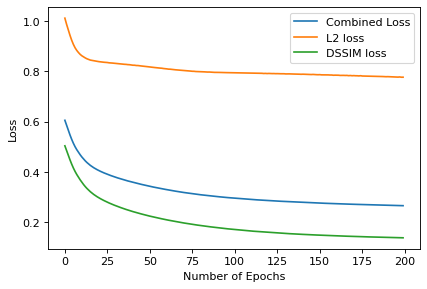

In [58]:
plt.plot(Epoch_Loss, label = 'Combined Loss')
plt.plot(Epoch_L2, label = 'L2 loss')
plt.plot(Epoch_DSSIM, label = 'DSSIM loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

## Plot train and validation

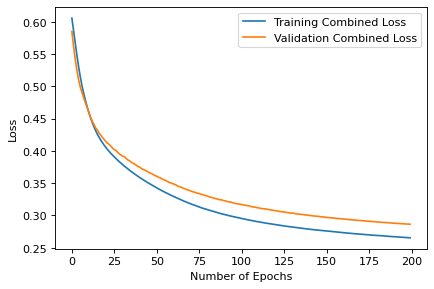

In [59]:
plt.plot(Epoch_Loss, label = 'Training Combined Loss')
plt.plot(Val_Epoch_Loss, label = 'Validation Combined Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

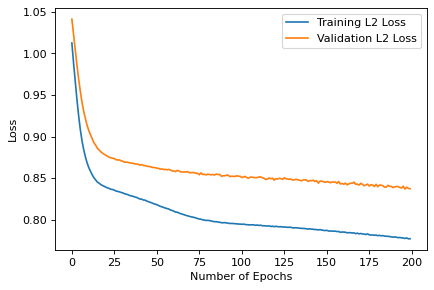

In [61]:
plt.plot(Epoch_L2, label = 'Training L2 Loss')
plt.plot(Val_Epoch_L2, label = 'Validation L2 Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

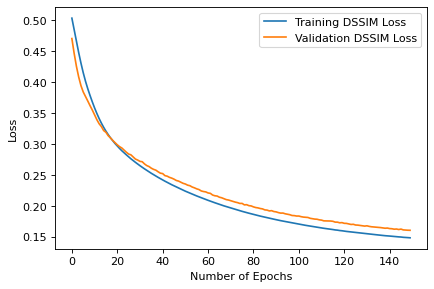

In [55]:
plt.plot(Epoch_DSSIM, label = 'Training DSSIM Loss')
plt.plot(Val_Epoch_DSSIM, label = 'Validation DSSIM Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

## Plot Pred images (Pred0 to Pred2)

In [40]:
path = '/content/gdrive/MyDrive/CUDA/Output Images/MMNIST/Pred/'
version = 1

In [ ]:
counter = 0
i = 0# Instance number
b = 16  #8Batch Size
for i in range(16):
  print("**********************************", i , "****************************************************")
  plt.imshow(Pred[i].reshape([height,width]).detach().cpu(), cmap = 'gray')
  plt.savefig(path+'Version'+str(version)+'_Pred'+str(counter)+'.png')
  plt.pause(1)
  plt.imshow(Pred[i + b ].reshape([height,width]).detach().cpu(), cmap = 'gray')
  plt.savefig(path+'Version'+str(version)+'_Pred'+str(counter+1)+'.png')
  plt.pause(1)
  plt.imshow(Pred[i + 2*b].reshape([height,width]).detach().cpu(), cmap = 'gray')
  plt.savefig(path+'Version'+str(version)+'_Pred'+str(counter+2)+'.png')
  plt.pause(1)
  counter = counter + 3
  

## Plot GT images (GT0 to GT2)

In [42]:
path = '/content/gdrive/MyDrive/CUDA/Output Images/MMNIST/GT/'
version = 0

In [ ]:
counter = 0
for i in range(16):
  for j in range(0,3):
    plt.imshow(frames[1][i,j,:,:,:].reshape([width,height]).detach().cpu(), cmap = 'gray')
    plt.savefig(path+'Version'+str(version)+'_GT'+str(counter)+'.png')
    plt.pause(1)
    #print("done",i,j,counter)
    counter = counter + 1
    
  for j in range(0,3):
    plt.imshow(frames[2][i,j,:,:,:].reshape([width,height]).detach().cpu(), cmap = 'gray')
    plt.savefig(path+'Version'+str(version)+'_GT'+str(counter)+'.png')
    plt.pause(1)
    #print("done",i,j,counter)
    counter = counter + 1
  


## Plot GT images (GT3 to GT5)

In [ ]:

i = 6
for i in range(5):
  plt.imshow(frames[2][i,0,:,:,:].reshape([width,height]).detach().cpu(), cmap = 'gray')
  plt.savefig(path+'Version'+str(version)+'_Pred'+str(counter)+'.png')
  plt.pause(1)
  plt.imshow(frames[2][i,1,:,:,:].reshape([width,height]).detach().cpu(), cmap = 'gray')
  plt.savefig(path+'Version'+str(version)+'_Pred'+str(counter)+'.png')
  plt.pause(1)
  plt.imshow(frames[2][i,2,:,:,:].reshape([width,height]).detach().cpu(), cmap = 'gray')
  plt.savefig(path+'Version'+str(version)+'_Pred'+str(counter)+'.png')
  plt.pause(1)